# Import

In [1]:
import argparse
import datetime
import os
import sys
import traceback
import matplotlib.pyplot as plt

import numpy as np

from astropy import units as u

# Import sotodlib.toast first, since that sets default object names
# to use in toast.
import sotodlib.toast as sotoast

import toast
import toast.ops

from toast.mpi import MPI, Comm

from toast import spt3g as t3g

if t3g.available:
    from spt3g import core as c3g

import sotodlib.toast.ops as so_ops
import sotodlib.mapmaking

# Make sure pixell uses a reliable FFT engine
import pixell.fft
pixell.fft.engine = "fftw"

# Load Schedule

In [2]:
schedule = toast.schedule.GroundSchedule()
schedule.read('/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt')

TOAST INFO: Loading schedule from /homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt
TOAST INFO: Loaded 1 scans from /homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt totaling 46.5 minutes.


# Get SO FocalPlane

In [3]:
# sample_rate = 10. #Hz
# focalplane = sotoast.SOFocalplane(
#         hwfile=None,
#         telescope='SAT1',
#         sample_rate=sample_rate * u.Hz,
#         bands='SAT_f090,SAT_f150',
#         wafer_slots='w25,w26,w27,w28,w29,w30,w31',
#         tube_slots=None,
#         thinfp=None,
#         comm=None,
#     )

sample_rate = 10. #Hz
focalplane = sotoast.SOFocalplane(
        hwfile=None,
        telescope='SAT1',
        sample_rate=sample_rate * u.Hz,
        bands='SAT_f090',
        wafer_slots='w25',
        tube_slots=None,
        thinfp=None,
        comm=None,
    )

TOAST INFO: Simulating default hardware configuration
TOAST INFO: 860 detectors match query: telescope=SAT1, tube_slots=None, wafer_slots=w25, bands=SAT_f090, thinfp=None


# Create Telescope

In [4]:
telescope = toast.Telescope(name="SAT1", focalplane=focalplane, 
                        site=toast.GroundSite("Atacama", schedule.site_lat,
                                                schedule.site_lon, schedule.site_alt))

# Data

In [5]:
data = toast.Data()

def plot_one_timestream(data):
    obs = data.obs[0]
    dets = obs.local_detectors

    fig, ax = plt.subplots(1,1,figsize=(3,1))
    ax.plot(obs.shared["times"], obs.detdata["signal"][dets[0]])
    ax.set_xlabel('utc')
    ax.set_ylabel('Kcmb')


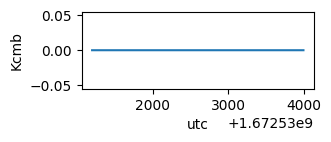

In [10]:
sim_gnd = toast.ops.SimGround(
        telescope=telescope,
        schedule=schedule,
        weather="atacama",
        hwp_angle='hwp_angle',
        hwp_rpm=120,
    )
sim_gnd.apply(data)
plot_one_timestream(data)

# Noise

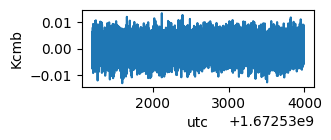

In [30]:
noise_model = toast.ops.DefaultNoiseModel(name='default_model', noise_model='noise_model')
noise_model.apply(data)

sim_noise = toast.ops.SimNoise()
sim_noise.apply(data)

plot_one_timestream(data)

# Pointing

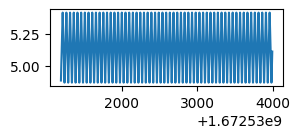

In [39]:
det_pointing_radec =toast.ops.PointingDetectorSimple(name='det_pointing_radec', quats='quats_radex', shared_flags=None)
det_pointing_radec.boresight = sim_gnd.boresight_radec
det_pointing_radec.apply(data)

det_pointing_azel =toast.ops.PointingDetectorSimple(name='det_pointing_azel', quats='quats_azel', shared_flags=None)
det_pointing_azel.boresight = sim_gnd.boresight_azel
det_pointing_azel.apply(data)

fig,ax = plt.subplots(1,1,figsize=(3,1))
ax.plot(data.obs[0].shared['times'], data.obs[0].shared['azimuth'])

# Elevation Noise model

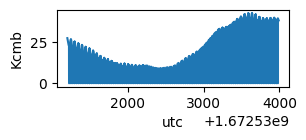

In [62]:
elevation_model = toast.ops.ElevationNoise(name='default_model')

elevation_model.detector_pointing = det_pointing_azel
elevation_model.apply(data)

plot_one_timestream(data)

# Stokes Weights Radec

In [56]:
weights_radec = toast.ops.stokes_weights.StokesWeights(
    mode = "IQU", # The Stokes weights to generate (I or IQU)
    name = "weights_radec", # The 'name' of this class instance,
    hwp_angle = "hwp_angle"
)

weights_radec.detector_pointing = det_pointing_radec
weights_radec.apply(data)

# Stokes Weights Azel

In [57]:
weights_azel = toast.ops.stokes_weights.StokesWeights(
    mode = "IQU", # The Stokes weights to generate (I or IQU)
    name = "weights_azel", # The 'name' of this class instance,
    hwp_angle = "hwp_angle"
)

weights_azel.detector_pointing = det_pointing_azel
weights_azel.apply(data)

# Atmosphere

In [55]:
sim_atmosphere_coarse = toast.ops.SimAtmosphere(
                                                name="sim_atmosphere_coarse",
                                                add_loading=False,
                                                lmin_center=300 * u.m,
                                                lmin_sigma=30 * u.m,
                                                lmax_center=10000 * u.m,
                                                lmax_sigma=1000 * u.m,
                                                xstep=50 * u.m,
                                                ystep=50 * u.m,
                                                zstep=50 * u.m,
                                                zmax=2000 * u.m,
                                                nelem_sim_max=30000,
                                                gain=6e-4,
                                                realization=1000000,
                                                wind_dist=10000 * u.m,
                                                enabled=True,
                                            )

sim_atmosphere = toast.ops.SimAtmosphere(
                                        name="sim_atmosphere",
                                        add_loading=True,
                                        lmin_center=0.001 * u.m,
                                        lmin_sigma=0.0001 * u.m,
                                        lmax_center=1 * u.m,
                                        lmax_sigma=0.1 * u.m,
                                        xstep=5 * u.m,
                                        ystep=5 * u.m,
                                        zstep=5 * u.m,
                                        zmax=200 * u.m,
                                        gain=6e-5,
                                        wind_dist=3000 * u.m,
                                        enabled=True,
                                    )


for sim_atm in sim_atmosphere_coarse, sim_atmosphere:
    if not sim_atm.enabled:
        continue
    sim_atm.detector_pointing = det_pointing_azel
    #if sim_atm.polarization_fraction != 0:
    #    sim_atm.detector_weights = ops.weights_azel    
    sim_atm.apply(data)

In [52]:
len(sim_atmosphere)

1